In [2]:
require 'nn'
require 'torch'
require 'optim'
require 'misc.DataLoader'
require 'misc.word_level'
require 'misc.phrase_level'
require 'misc.ques_level'
require 'misc.recursive_atten'
require 'misc.cnnModel'
require 'misc.optim_updates'
utils = require 'misc.utils'
require 'xlua'
require 'image'


opt = {}

opt.vqa_model = 'model/vqa_model/model_alternating_train_vgg.t7'
opt.cnn_proto = 'image_model/VGG_ILSVRC_19_layers_deploy.prototxt'
opt.cnn_model = 'image_model/VGG_ILSVRC_19_layers.caffemodel'
opt.json_file = 'data/vqa_data_prepro.json'
opt.backend = 'cudnn'
opt.gpuid = 1
if opt.gpuid >= 0 then
  require 'cutorch'
  require 'cunn'
  if opt.backend == 'cudnn' then 
  require 'cudnn' 
  end
  --cutorch.setDevice(opt.gpuid+1) -- note +1 because lua is 1-indexed
end

local loaded_checkpoint = torch.load(opt.vqa_model)
local lmOpt = loaded_checkpoint.lmOpt

lmOpt.hidden_size = 512
lmOpt.feature_type = 'VGG'
lmOpt.atten_type = 'Alternating'
cnnOpt = {}
cnnOpt.cnn_proto = opt.cnn_proto
cnnOpt.cnn_model = opt.cnn_model
cnnOpt.backend = opt.backend
cnnOpt.input_size_image = 512
cnnOpt.output_size = 512
cnnOpt.h = 14
cnnOpt.w = 14
cnnOpt.layer_num = 37

-- load the vocabulary and answers.

local json_file = utils.read_json(opt.json_file)
ix_to_word = json_file.ix_to_word
ix_to_ans = json_file.ix_to_ans

word_to_ix = {}
for ix, word in pairs(ix_to_word) do
    word_to_ix[word]=ix
end

-- load the model
protos = {}
protos.word = nn.word_level(lmOpt)
protos.phrase = nn.phrase_level(lmOpt)
protos.ques = nn.ques_level(lmOpt)

protos.atten = nn.recursive_atten()
protos.crit = nn.CrossEntropyCriterion()
protos.cnn = nn.cnnModel(cnnOpt)

if opt.gpuid >= 0 then
  for k,v in pairs(protos) do v:cuda() end
end

cparams, grad_cparams = protos.cnn:getParameters()
wparams, grad_wparams = protos.word:getParameters()
pparams, grad_pparams = protos.phrase:getParameters()
qparams, grad_qparams = protos.ques:getParameters()
aparams, grad_aparams = protos.atten:getParameters()

print('Load the weight...')
wparams:copy(loaded_checkpoint.wparams)
pparams:copy(loaded_checkpoint.pparams)
qparams:copy(loaded_checkpoint.qparams)
aparams:copy(loaded_checkpoint.aparams)

print('total number of parameters in cnn_model: ', cparams:nElement())
assert(cparams:nElement() == grad_cparams:nElement())

print('total number of parameters in word_level: ', wparams:nElement())
assert(wparams:nElement() == grad_wparams:nElement())

print('total number of parameters in phrase_level: ', pparams:nElement())
assert(pparams:nElement() == grad_pparams:nElement())

print('total number of parameters in ques_level: ', qparams:nElement())
assert(qparams:nElement() == grad_qparams:nElement())
protos.ques:shareClones()

print('total number of parameters in recursive_attention: ', aparams:nElement())
assert(aparams:nElement() == grad_aparams:nElement())

image_model/VGG_ILSVRC_19_layers_deploy.prototxt	image_model/VGG_ILSVRC_19_layers.caffemodel	cudnn	


Successfully loaded image_model/VGG_ILSVRC_19_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3


conv3_1: 256 128 3 3
conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv3_4: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv4_4: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


conv5_4: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


Load the weight...	
total number of parameters in cnn_model: 	20024384	
total number of parameters in word_level: 	8031747	
total number of parameters in phrase_level: 	2889219	
total number of parameters in ques_level: 	5517315	
constructing clones inside the ques_level	


total number of parameters in recursive_attention: 	2862056	


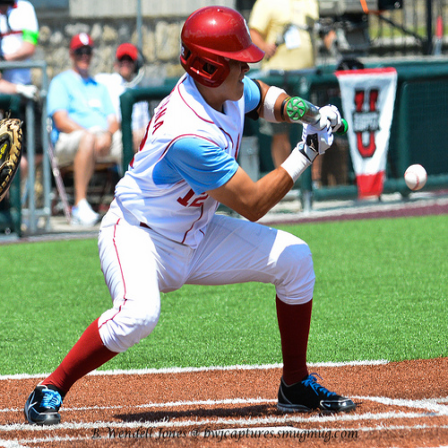

The answer is: red	


In [5]:
-- specify the image and the question.
local img_path = 'visu/demo_img1.jpg'
local question = 'what is the color of the hat ?'

-- load the image
local img = image.load(img_path)
-- scale the image
img = image.scale(img,448,448)
itorch.image(img)
img = img:view(1,img:size(1),img:size(2),img:size(3))
-- parse and encode the question (in a simple way).
local ques_encode = torch.IntTensor(26):zero()

local count = 1
for word in string.gmatch(question, "%S+") do
    ques_encode[count] = word_to_ix[word] or word_to_ix['UNK']
    count = count + 1
end
ques_encode = ques_encode:view(1,ques_encode:size(1))
-- doing the prediction

protos.word:evaluate()
protos.phrase:evaluate()
protos.ques:evaluate()
protos.atten:evaluate()
protos.cnn:evaluate()

local image_raw = utils.prepro(img, false)
image_raw = image_raw:cuda()
ques_encode = ques_encode:cuda()

local image_feat = protos.cnn:forward(image_raw)
local ques_len = torch.Tensor(1,1):cuda()
ques_len[1] = count-1

local word_feat, img_feat, w_ques, w_img, mask = unpack(protos.word:forward({ques_encode, image_feat}))
local conv_feat, p_ques, p_img = unpack(protos.phrase:forward({word_feat, ques_len, img_feat, mask}))
local q_ques, q_img = unpack(protos.ques:forward({conv_feat, ques_len, img_feat, mask}))

local feature_ensemble = {w_ques, w_img, p_ques, p_img, q_ques, q_img}
local out_feat = protos.atten:forward(feature_ensemble)

local tmp,pred=torch.max(out_feat,2)
local ans = ix_to_ans[tostring(pred[1][1])]

print('The answer is: ' .. ans)

In [ ]:
-- Attention Visualization


